Thesis project by: Valerio Tinari

Topic: Anomaly Detection using Transformer architecture

Dataset: LHC Olympics 2020 dataset

In [ ]:
#Import packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import time

import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)
import torch.nn as nn
import torch.nn.functional as F

import sys
import dgl
import imp
import os
import json

sys.path.append('/home/Valerio/')
from dataset.fast_perjet import LHCDatasetPerJet
from torch.utils.data import DataLoader, TensorDataset


1.13.1+cu117
0.14.1+cu117


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  app.launch_new_instance()


In [2]:
# define device to use (cpu/gpu)
if torch.cuda.is_available():
    print('# of GPUs available: ', torch.cuda.device_count())
    print('First GPU type: ',torch.cuda.get_device_name(0))
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

# of GPUs available:  1
First GPU type:  Tesla V100-SXM2-32GB
Computation device: cuda



### Configurations

In [3]:
def myStandardScaler(data, info):
    const, label = data 
    
    const[:, 0] = (const[:, 0] - info['mean_pt']) / info['std_pt']
    const[:, 1] = (const[:, 1] - info['mean_eta']) / info['std_eta']
    const[:, 2] = (const[:, 2] - info['mean_phi']) / info['std_phi']
    
    return const, label

def check_positive_values(num_train_bkg, num_train_sig, num_val_bkg, num_val_sig, num_test_bkg, num_test_sig):
    if any(value < 0 for value in [num_train_bkg, num_train_sig, num_val_bkg, num_val_sig, num_test_bkg, num_test_sig]):
        raise ValueError("All variables must be positive.")

def vec_splitting(dataset, batch_size, train_lim, val_lim, test_lim, num_workers):
    num_examples = len(dataset)

    num_train_bkg = train_lim[0][1] - train_lim[0][0]
    num_train_sig = train_lim[1][1] - train_lim[1][0]
    num_val_bkg = val_lim[0][1] - val_lim[0][0]
    num_val_sig = val_lim[1][1] - val_lim[1][0]
    num_test_bkg = test_lim[0][1] - test_lim[0][0]
    num_test_sig = test_lim[1][1] - test_lim[1][0]
    check_positive_values(num_train_bkg, num_train_sig, num_val_bkg, num_val_sig, num_test_bkg, num_test_sig)
    print(f'Training:\t{num_train_bkg} background and {num_train_sig} signal events')
    print(f'Validation:\t{num_val_bkg} background and {num_val_sig} signal events')
    print(f'Test:\t\t{num_test_bkg} background and {num_test_sig} signal events')
    
    indices_train_bkg = train_lim[0][0] + torch.randperm(num_train_bkg)
    indices_train_sig = train_lim[1][0] + torch.randperm(num_train_sig)
    indices_train = torch.cat((indices_train_bkg, indices_train_sig))
    indices_train = indices_train[torch.randperm(num_train_bkg + num_train_sig)]
    #print(indices_train)
    indices_val_bkg = val_lim[0][0] + torch.randperm(num_val_bkg)
    indices_val_sig = val_lim[1][0] + torch.randperm(num_val_sig)
    indices_val = torch.cat((indices_val_bkg, indices_val_sig))
    indices_val = indices_val[torch.randperm(num_val_bkg + num_val_sig)]
    #print(indices_val)
    indices_test_bkg = test_lim[0][0] + torch.randperm(num_test_bkg)
    indices_test_sig = test_lim[1][0] + torch.randperm(num_test_sig)
    indices_test = torch.cat((indices_test_bkg, indices_test_sig))
    indices_test = indices_test[torch.randperm(num_test_bkg + num_test_sig)]
    #print(indices_test)
    
    train_dataloader = DataLoader(dataset, sampler=indices_train, batch_size=batch_size, drop_last=False, 
                                  shuffle=False, num_workers=num_workers)
    valid_dataloader = DataLoader(dataset, sampler=indices_val, batch_size=batch_size, drop_last=False,
                                  shuffle=False, num_workers=num_workers)
    test_dataloader = DataLoader(dataset, sampler=indices_test, batch_size=batch_size, drop_last=False, 
                                 shuffle=False, num_workers=num_workers)
    
    return train_dataloader, valid_dataloader, test_dataloader

In [ ]:
data_dir = '/home/Valerio/dataset_NOtransf_rotation/'

file_pattern = 'batch_(\d+)_(\d+).pt'
io_cachesize = 100 # number of files to keep in memory at the same time
verbose = True
batch_size = 512
is_sup = False
max_jets = 2
device = ('cuda' if torch.cuda.is_available() else 'cpu') 

if not is_sup: 
    print(f'is_sup: {is_sup}')
    train_lim = [[0*max_jets, 800000*max_jets], [1000000*max_jets, 1000000*max_jets]]
    val_lim = [[800000*max_jets, 900000*max_jets], [1000000*max_jets, 1000001*max_jets]]
    test_lim = [[900000*max_jets, 1000000*max_jets], [1000000*max_jets, 1100000*max_jets]]
    
else: 
    print(f'is_sup: {is_sup}')
    train_lim = [[0*max_jets, 80000*max_jets], [1000000*max_jets, 1080000*max_jets]]
    val_lim = [[80000*max_jets, 90000*max_jets], [1080000*max_jets, 1090000*max_jets]]
    test_lim = [[90000*max_jets, 100000*max_jets], [1090000*max_jets, 1100000*max_jets]]

is_sup: False


## Dataset loading to find the best Normalization

In [ ]:
NormalizationSearch = None
datasetNotNorm = LHCDatasetPerJet(jets_to_take=max_jets, data_dir=data_dir,
                       file_pattern=file_pattern, cache_size=io_cachesize, read_full=True, 
                       verbose=verbose, transform=NormalizationSearch)

In [8]:
indice = 1 #it should be 0 <= indice < 2200000

print(f'The dataset is created from the path {data_dir}')
print(f'\nThe variable dataset contains {len(datasetNotNorm)} events, each element of the dataset is a {type(datasetNotNorm[indice])} of length {len(datasetNotNorm[indice])}.')
print(f'The first element is a {type(datasetNotNorm[indice][0])} of shape {datasetNotNorm[indice][0].shape} (50 constituents, pt, eta, phi for each)')
print(f'The first element is a {type(datasetNotNorm[indice][1])}, e.g. {datasetNotNorm[indice][1]} (0 = background; 1 = signal)')

The dataset is created from the path /raid/home/russogra/xValerio/dataset_furbo_NOtransf_rotation/

The variable dataset contains 2200000 events, each element of the dataset is a <class 'tuple'> of length 2.
The first element is a <class 'torch.Tensor'> of shape torch.Size([50, 3]) (50 constituents, pt, eta, phi for each)
The first element is a <class 'numpy.float64'>, e.g. 0.0 (0 = background; 1 = signal)


In [9]:
start_time = time.time()

ptPlot=[]
etaPlot=[]
phiPlot=[]
signalPt=[]
signalEta=[]
signalPhi=[]

for i in range (len(datasetNotNorm)):
    if datasetNotNorm[i][1]==0:
        ptPlot.append(datasetNotNorm[i][0][:,0].numpy())
        etaPlot.append(datasetNotNorm[i][0][:,1].numpy())
        phiPlot.append(datasetNotNorm[i][0][:,2].numpy())
    else:
        signalPt.append(datasetNotNorm[i][0][:,0].numpy())
        signalEta.append(datasetNotNorm[i][0][:,1].numpy())
        signalPhi.append(datasetNotNorm[i][0][:,2].numpy())
        
ptPlot=np.array(ptPlot).flatten()
etaPlot=np.array(etaPlot).flatten()
phiPlot=np.array(phiPlot).flatten()
signalPt=np.array(signalPt).flatten()
signalEta=np.array(signalEta).flatten()
signalPhi=np.array(signalPhi).flatten()

finish_time = time.time()

In [10]:
#Check
#saving only value different from 0
phiPlotNP=phiPlot[ptPlot!=0]
etaPlotNP=etaPlot[ptPlot!=0]
ptPlotNP=ptPlot[ptPlot!=0]
signalPhiNP=signalPhi[signalPt!=0]
signalEtaNP=signalEta[signalPt!=0]
signalPtNP=signalPt[signalPt!=0]
print("pt plot shape: ",ptPlotNP.shape)
print("eta plot shape: ",etaPlotNP.shape)
print("phi plot shape: ",phiPlotNP.shape)
print(f'Total run_time is: {finish_time-start_time} s')

#phiPlotNP stands for NoPadding

pt plot shape:  (83680010,)
eta plot shape:  (83680010,)
phi plot shape:  (83680010,)
Total run_time is: 116.0967743396759 s


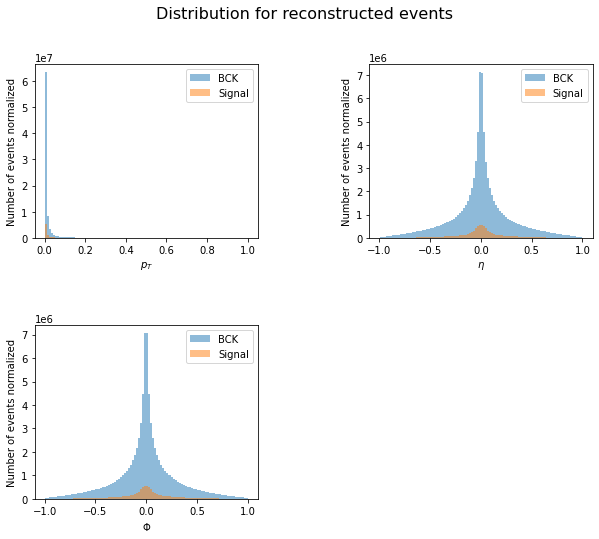

Total run_time is: 5.939229249954224 s


In [11]:
start_time = time.time()
Plotarrays=[ptPlotNP,etaPlotNP,phiPlotNP]
PlotarraysSignal=[signalPtNP,signalEtaNP,signalPhiNP]

labels=['$p_T$','$\eta$','$\Phi$']
colors=['g','r','b']

#Distribution for background events
fig = plt.figure(figsize=(10,8))
fig.suptitle('Distribution for reconstructed events', fontsize=16)

for i in range(0,len(Plotarrays)):
    fig.subplots_adjust(wspace=0.5)
    fig.subplots_adjust(hspace=0.5)
    ax = fig.add_subplot(2, 2, i+1)
    ax.hist(Plotarrays[i], bins=100,density=False, alpha=0.5,label='BCK')
    ax.hist(PlotarraysSignal[i], bins=100,density=False, alpha=0.5,label='Signal')
    plt.xlabel(labels[i])
    plt.ylabel('Number of events normalized')
    plt.legend(loc='upper right')

plt.savefig("ModelScan/Final/DataDistribution.pdf")    
plt.show()
print(f'Total run_time is: {time.time()-start_time} s')

In [12]:
#Calculating mean and STD of each feature
ptmean=ptPlotNP.mean()
etamean=etaPlotNP.mean()
phimean=phiPlotNP.mean()
ptstd=ptPlotNP.std()
etastd=etaPlotNP.std()
phistd=phiPlotNP.std()

print("pT mean is: ",ptmean)
print("pT std is: ",ptstd)
print("\neta mean is: ",etamean)
print("eta std is: ",etastd)
print("\nphi mean is: ",phimean)
print("phi std is: ",phistd)

pT mean is:  0.016317237
pT std is:  0.050027333

eta mean is:  0.00014387858
eta std is:  0.2930633

phi mean is:  0.000104344545
phi std is:  0.29033494


# Vectorial dataset loading

standardScaler_transformedOLD = {'mean_pt': 0.016302107, 
                              'mean_eta': 2.9857304e-07,
                              'mean_phi': -0.00055650854,
                              'std_pt': 0.050019808,
                              'std_eta': 0.7675579,
                              'std_phi': 1.8149211}

standardScaler_transformedPlus0 = {'mean_pt': 0.013623734, 
                              'mean_eta': -204623970.0,
                              'mean_phi': -0.0004650763,
                              'std_pt': 0.046123847,
                              'std_eta': 4518965000.0,
                              'std_phi': 1.659144} 


In [13]:
standardScaler_transformed = {'mean_pt': ptmean, 
                              'mean_eta': etamean,
                              'mean_phi': phimean,
                              'std_pt': ptstd,
                              'std_eta': etastd,
                              'std_phi': phistd}

Note:

standardScaler_transformedPlus0 is the dict containing normalization values calculated considering also pt==0
standardScaler_transformed instead contains only physical events with pt!=0

In [ ]:
Normalization =lambda x: myStandardScaler(x, standardScaler_transformed)
dataset = LHCDatasetPerJet(jets_to_take=max_jets, data_dir=data_dir,
                       file_pattern=file_pattern, cache_size=io_cachesize, read_full=True, 
                       verbose=verbose, transform=Normalization)

In [15]:
indice = 1 #it should be 0 <= indice < 2200000

print(f'The dataset is created from the path {data_dir}')
print(f'\nThe variable dataset contains {len(dataset)} events, each element of the dataset is a {type(dataset[indice])} of length {len(dataset[indice])}.')
print(f'The first element is a {type(dataset[indice][0])} of shape {dataset[indice][0].shape} (50 constituents, pt, eta, phi for each)')
print(f'The first element is a {type(dataset[indice][1])}, e.g. {dataset[indice][1]} (0 = background; 1 = signal)')

The dataset is created from the path /raid/home/russogra/xValerio/dataset_furbo_NOtransf_rotation/

The variable dataset contains 2200000 events, each element of the dataset is a <class 'tuple'> of length 2.
The first element is a <class 'torch.Tensor'> of shape torch.Size([50, 3]) (50 constituents, pt, eta, phi for each)
The first element is a <class 'numpy.float64'>, e.g. 0.0 (0 = background; 1 = signal)


#### Checking Plot 

In [16]:
start_time2 = time.time()

ptPlot2=[]
etaPlot2=[]
phiPlot2=[]
signalPt2=[]
signalEta2=[]
signalPhi2=[]

for i in range (len(dataset)):
    if dataset[i][1]==0:
        ptPlot2.append(dataset[i][0][:,0].numpy())
        etaPlot2.append(dataset[i][0][:,1].numpy())
        phiPlot2.append(dataset[i][0][:,2].numpy())
    else:
        signalPt2.append(dataset[i][0][:,0].numpy())
        signalEta2.append(dataset[i][0][:,1].numpy())
        signalPhi2.append(dataset[i][0][:,2].numpy())

ptPlot2=np.array(ptPlot2).flatten()
etaPlot2=np.array(etaPlot2).flatten()
phiPlot2=np.array(phiPlot2).flatten()
signalPt2=np.array(signalPt2).flatten()
signalEta2=np.array(signalEta2).flatten()
signalPhi2=np.array(signalPhi2).flatten()

finish_time = time.time()

In [17]:
#Check
print("BCK pt shape: ",ptPlot2.shape)
print("BCK eta shape: ",etaPlot2.shape)
print("BCK phi shape: ",phiPlot2.shape)
print("signal Pt shape: ",signalPt2.shape)
print("signal Eta shape: ",signalEta2.shape)
print("signal Phi shape: ",signalPhi2.shape)
print(f'Total run_time is: {finish_time-start_time2} s')

BCK pt shape:  (100000000,)
BCK eta shape:  (100000000,)
BCK phi shape:  (100000000,)
signal Pt shape:  (10000000,)
signal Eta shape:  (10000000,)
signal Phi shape:  (10000000,)
Total run_time is: 290.2991373538971 s


In [18]:
#Calculating mean and STD of each feature
ptmean2=ptPlot2.mean()
etamean2=etaPlot2.mean()
phimean2=phiPlot2.mean()
ptstd2=ptPlot2.std()
etastd2=etaPlot2.std()
phistd2=phiPlot2.std()

print("pT mean is: ",ptmean2)
print("pT std is: ",ptstd2)
print("\neta mean is: ",etamean2)
print("eta std is: ",etastd2)
print("\nphi mean is: ",phimean2)
print("phi std is: ",phistd2)

pT mean is:  0.00804375
pT std is:  0.067736834

eta mean is:  -0.006236444
eta std is:  1.7658879

phi mean is:  -0.006359921
phi std is:  1.7788271


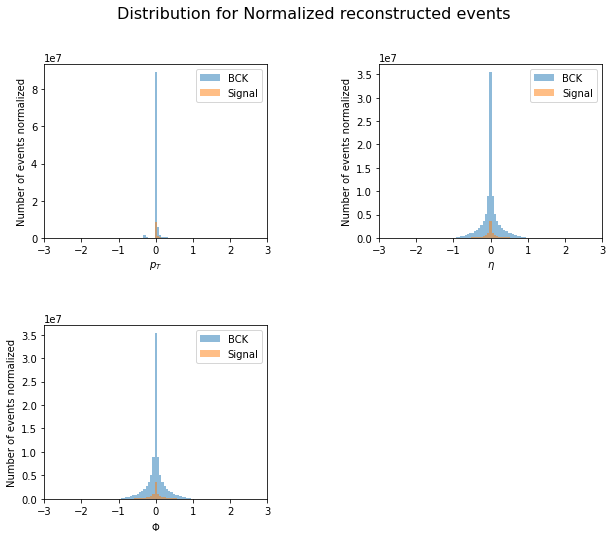

Total run_time is: 20.439955711364746 s


In [19]:
start_time = time.time()
Plotarrays2=[ptPlot2,etaPlot2,phiPlot2]
PlotarraysSignal2=[signalPt2,signalEta2,signalPhi2]

#Distribution for background events
fig = plt.figure(figsize=(10,8))
fig.suptitle('Distribution for Normalized reconstructed events', fontsize=16)

nbins=np.linspace(-3,3,100)

for i in range(0,len(Plotarrays)):
    fig.subplots_adjust(wspace=0.5)
    fig.subplots_adjust(hspace=0.5)
    ax = fig.add_subplot(2, 2, i+1)
    ax.hist(Plotarrays2[i], bins=nbins,density=False, alpha=0.5,label='BCK')
    ax.hist(PlotarraysSignal2[i], bins=nbins,density=False, alpha=0.5,label='Signal')
    plt.xlim(-3,3)
    plt.xlabel(labels[i])
    plt.ylabel('Number of events normalized')
    plt.legend(loc='upper right')

plt.savefig("ModelScan/Final/DistributionNORM.pdf")    
plt.show()
print(f'Total run_time is: {time.time()-start_time} s')

In [20]:
train_loader, val_loader, test_loader = vec_splitting(dataset, batch_size, train_lim, val_lim, test_lim, 0)
len(train_loader), len(val_loader), len(test_loader)

Training:	1600000 background and 0 signal events
Validation:	200000 background and 2 signal events
Test:		200000 background and 200000 signal events


(3125, 391, 782)

#########

### Defining the model architecture

The model architecture is based on two python classes inheriting from pytroch nn.Module:

-AttentionBlock: implements the standard attention (multi-head attention + MLP) block for a tranformer encoder architecture  \\\
-TransformerModel: a classifier based on a transformer encoder architecture implementation

In [21]:
class AttentionBlock(nn.Module):
    #  Implements the standard attention (multi-head attention + MLP) block for
    #  a tranformer encoder architecture

    #  arguments:
    #   embed_dim  - Dimensionality of input and attention feature vectors
    #   hidden_dim - Dimensionality of hidden layer in feed-forward network (usually 2-4x larger than embed_dim)
    #   num_heads  - Number of heads to use in the Multi-Head Attention block
    #   dropout    - Amount of dropout to apply in the feed-forward network


    def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
        super(AttentionBlock, self).__init__()

        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True) #this pytroch function implements a full MHA block
        self.layer_norm_2 = nn.LayerNorm(embed_dim)

        #MLP made by: Linear layer with GELU activation, a dropout layer, another Linear layer w/o activation floowed by another dropout layer.
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim,hidden_dim),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(hidden_dim,embed_dim),
            nn.Dropout(p=dropout),
            )

    def forward(self, x):
        inp_x = self.layer_norm_1(x)
        xMha = x + self.attn(inp_x, inp_x, inp_x)[0] #nn.MultiheadAttention expects input shapes 3x(L,B,F) and output
        xMha = self.layer_norm_2(xMha)
        x=x+self.mlp(xMha)
        return x

In [22]:
class TransformerModel(nn.Module):
    #  Transformer encoder architecture implementation, trained to reconstruct input_data

    #  arguments:
    #   input_dim  - Dimensionality of input feature vectors (jet features)
    #   embed_dim  - Dimensionality of embedding in input to the Transformer
    #   hidden_dim - Dimensionality of hidden layer in feed-forward network
    #   num_heads  - Number of heads to use in the Multi-Head Attention block
    #   num_layers - Number of layers to use in the Transformer
    #   dropout    - Amount of dropout to apply in the feed-forward network and in the input

    def __init__(self, input_dim, embed_dim, hidden_dim, num_heads, num_layers, dropout=0.0):
        super(TransformerModel, self).__init__()

        # input layer (a dense MLP projecting the input in a embed_dim embedding space)
        self.input_layer = nn.Sequential(
            nn.Linear(input_dim,128),
            nn.GELU(),
            nn.Linear(128,512),
            nn.GELU(),
            nn.Linear(512,embed_dim),
            nn.GELU()
        )

        # Transformer encoder: stack of num_layers Attention Blocks (embed_dim -> embed_dim)
        self.transformer = nn.Sequential(*[AttentionBlock(embed_dim, hidden_dim, num_heads, dropout=dropout) for _ in range(num_layers)])
         
        #option 2, a bit lighter
        self.output_layer = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim,input_dim)
        )

        self.dropout = nn.Dropout(dropout)


    def forward(self, x):
        # project input into the embed_dim space and applying dropout
        x = self.input_layer(x)
        x=self.dropout(x)

        # Apply Transformer
        x=self.transformer(x)

        #MLP to go back to input vector dim
        x=self.output_layer(x)
        return x

## Scan of hyperparameters

In [674]:
#def trainingLoop(train_loader,val_loader,model,device,epochs,loss_func,numLayer,numHead,LR,schedulerSet=False):
#def testPlot(bckAS,sgnAS,numLayer,numHead):
#def testLoop(test_loader,model_kwargs,runningKwargs):

### Number of epochs

In [ ]:
import trainingFunctionsFinal as tF

headList=[2,4,8]
layerList=[4,8,16,32]
LRlist=[1e-6]

loss_func = nn.MSELoss()

for k in LRlist:
    for i in layerList:
        for j in headList:
            
            # instantiate the model
            model_kwargs={
                'input_dim': 3,
                'embed_dim': 128,
                'hidden_dim': 256,
                'num_heads': j,
                'num_layers': i,
                'dropout': 0.30}
            
            print("num heads{0}; num Layers {1}".format(model_kwargs['num_heads'],model_kwargs['num_layers']))
            
            model = TransformerModel(**model_kwargs)
            
            runningKwargs={
                  'model': model,
                  'device':device,
                  'epochs': 50,
                  'loss_func': loss_func,
                  'numLayer': i,
                  'numHead': j,
                  'LR': k,
                  'schedulerSet':False}
            
            hist_loss,hist_vloss=tF.trainingLoop(train_loader,val_loader,**runningKwargs)
            tF.trainingPlot(hist_loss,hist_vloss,runningKwargs['numHead'],runningKwargs['numLayer'],runningKwargs['LR'])
            
            #Loading the best model
            filename='ModelScan/Final/best_modelL'+str(runningKwargs['numLayer'])+'H'+str(runningKwargs['numHead'])+str(runningKwargs['LR'])+'.pth'
            checkpoint = torch.load(filename)
            device=runningKwargs['device']
            model = TransformerModel(**model_kwargs)
            model.load_state_dict(checkpoint['model_state_dict'])
            model.eval()
            model.to(device)
            print('Loaded best model at epoch: ', checkpoint['epoch'])
            
            tF.testLoop(test_loader,model,runningKwargs['device'],runningKwargs['numHead'],runningKwargs['numLayer'],runningKwargs['LR'])

print("Loop Completed, check results")


num heads2; num Layers 4

Best validation loss: 0.8907764808601125

Saving best model for epoch: 1

epoch: 1, time(s): 140.51, train loss: 1.576337, vali loss: 0.890776

Best validation loss: 0.7459701459730983

Saving best model for epoch: 2

epoch: 2, time(s): 132.64, train loss: 1.025932, vali loss: 0.745970


Output successfully saved to the destination directory!